In [1]:
!pip install Keras
import time
import numpy as np
import pandas as pd
import operator
#import dill as pkl
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
#import nltk
#import re
import itertools
#import unittest
#import RegexTester
#from nltk.stem import WordNetLemmatizer
#import nltk
#from nltk.corpus import wordnet
%matplotlib inline
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
#from keras.preprocessing.sequence import pad_sequences
#from keras.utils.np_utils import to_categorical
#from keras.optimizers import SGD

#from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Dropout
from keras.models import Model, load_model, Sequential
#from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
#from keras.callbacks import History, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, auc

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/sharadv/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# LOAD Pre-processed DATA from Analysis notebook

In [2]:
full_data = pd.read_pickle("./full_data.pkl")

# TRAIN/TEST SPLIT

In [3]:
train_set, test_set = train_test_split(full_data, test_size=0.10, random_state=42)

#Separate training set into train and dev. Roughly 80% of original data is train, 10% dev, 10% test
train_set, dev_set = train_test_split(train_set, test_size=0.11, random_state=42)

# Oversampling algorithm - multi-label splitting

In [33]:
def oversample(df, max_records = 10):
    max_per_genre = int(max_records/10)
    new_df = pd.DataFrame(columns=list(df.columns))
    genre_count = defaultdict(int)
    record_count = 0
    while record_count < max_records:
        counter = 0
        sample = df.sample(1, replace = True)
        for i in list(itertools.chain(*sample["list_genres_consol"])):
            if genre_count[i] == max_per_genre:
                df = df[~df["list_genres_consol"].apply(lambda x: str(i) in x)]
                continue
            else:
                counter += 1
        if counter == len(sample["list_genres_consol"]):
            new_df = new_df.append(sample)
            record_count += 1
            for i in list(itertools.chain(*sample["list_genres_consol"])):
                genre_count[i] += 1
    return new_df

In [ ]:
#Generate sample
start = time.time()
sample_df = oversample(train_set, max_records=50000)
end = time.time()
print("Duration in seconds: ", end-start)

In [40]:
sample_count = defaultdict(int)

def count_genres(row):
    for i in row: 
        sample_count[i]+=1

In [41]:
len(sample_df)

50000

10.00% of the movies are Comedy
10.00% of the movies are Drama
10.00% of the movies are Thriller
10.00% of the movies are Adventure
10.00% of the movies are Sci-Fi
10.00% of the movies are Horror
10.00% of the movies are Family
10.00% of the movies are Action
10.00% of the movies are Crime
10.00% of the movies are Romance


[Text(0,0,'Comedy'),
 Text(0,0,'Drama'),
 Text(0,0,'Thriller'),
 Text(0,0,'Adventure'),
 Text(0,0,'Sci-Fi'),
 Text(0,0,'Horror'),
 Text(0,0,'Family'),
 Text(0,0,'Action'),
 Text(0,0,'Crime'),
 Text(0,0,'Romance')]

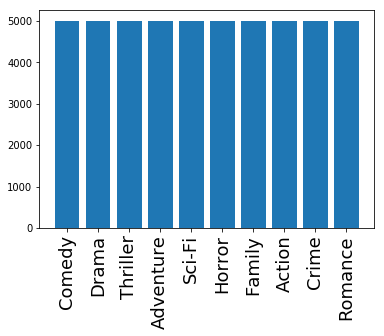

In [42]:
sample_df["list_genres_consol"].apply(lambda row: count_genres(row))

for key,val in sample_count.items():
    print("{:0.2f}% of the movies are {}".format(100*val/len(sample_df), key))



fig, ax = plt.subplots(1,1) 
ax.bar(range(len(sample_count.keys())), list(sample_count.values()))
ax.set_xticks(range(len(sample_count.keys())))
ax.set_xticklabels(list(sample_count.keys()), rotation='vertical', fontsize=18)

# Undersampling

In [ ]:
#Distribution of Genres - imbalanced 
count_dict_norm = defaultdict(int)

def dict_count(row, count_dict):
    for genre in row:
        count_dict[genre] += 1

        
count_dict_series = train_set["list_genres_consol"].apply(lambda row: dict_count(row, count_dict_norm))

sorted(count_dict_norm.items(), key=operator.itemgetter(1))

In [ ]:
def undersample_w_replacement(df, genre_counts):
    """There can be duplicates within genre samples, but not across genre samples"""
    max_records = sorted(genre_counts.items(), key=operator.itemgetter(1))[0][1] #num records for min class
    new_df = pd.DataFrame(columns=list(data.columns))
    for i in list(genre_counts.keys()):
        print(i)
        sample_df = df[df["list_genres_consol"].apply(lambda x: str(i) in x)]
        new_df = new_df.append(sample_df.sample(max_records, replace = True))
        df = df[~df["list_genres_consol"].apply(lambda x: str(i) in x)]
    return new_df.sample(frac=1) #shuffles the sample dataframe

def undersample_w_out_replacement(df, genre_counts):
    """There can be duplicates across genre samples, but not within genre samples"""
    max_records = sorted(genre_counts.items(), key=operator.itemgetter(1))[0][1] #num records for min class
    new_df = pd.DataFrame(columns=list(data.columns))
    for i in list(genre_counts.keys()):
        print(i)
        sample_df = df[df["list_genres_consol"].apply(lambda x: str(i) in x)]
        new_df = new_df.append(sample_df.sample(max_records, replace = False))
    return new_df.sample(frac=1) #shuffles the sample dataframe

In [ ]:
start = time.time()
new_train = undersample_w_out_replacement(train_set, count_dict_norm)
end = time.time()
print("total time: ", end-start, "seconds")

In [ ]:
#Sample without replacement - more balanced
count_dict_undersample_w_out_replacement = defaultdict(int)
count_val_series_2 = new_train["list_genres_consol"].apply(lambda row: dict_count(row, count_dict_undersample_w_out_replacement))
count_dict_undersample_w_out_replacement

In [ ]:
fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict_undersample_w_out_replacement.keys())), list(count_dict_undersample_w_out_replacement.values()))
ax.set_xticks(range(len(count_dict_undersample_w_out_replacement.keys())))
ax.set_xticklabels(list(count_dict_undersample_w_out_replacement.keys()), rotation='vertical', fontsize=18)

In [ ]:
#Sample with replacement - even more balanced but less variance within genres 
start = time.time()
new_train = undersample_w_replacement(train_set, count_dict_norm)
end = time.time()
print("total time: ", end-start, "seconds")

In [ ]:
count_dict_undersample_w_replacement = defaultdict(int)
count_val_series_2 = new_train["list_genres_consol"].apply(lambda row: dict_count(row, count_dict_undersample_w_replacement))
count_dict_undersample_w_replacement

In [ ]:
fig, ax = plt.subplots(1,1) 
ax.bar(range(len(count_dict_undersample_w_replacement.keys())), list(count_dict_undersample_w_replacement.values()))
ax.set_xticks(range(len(count_dict_undersample_w_replacement.keys())))
ax.set_xticklabels(list(count_dict_undersample_w_replacement.keys()), rotation='vertical', fontsize=18)

# BoW TFIDF

In [43]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(full_data["list_genres_consol"])

MAX_NB_WORDS = 80000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_set['flattened_tokens'])

# tokenizer.fit_on_texts(sample_df['flattened_tokens'])

In [44]:
x_train_bow = tokenizer.texts_to_matrix(train_set["flattened_tokens"], mode="tfidf")
print(x_train_bow.shape)
x_dev_bow = tokenizer.texts_to_matrix(dev_set["flattened_tokens"], mode="tfidf")
print(x_dev_bow.shape)
x_test_bow = tokenizer.texts_to_matrix(test_set["flattened_tokens"], mode = "tfidf")
print(x_test_bow.shape)

# x_train_bow = tokenizer.texts_to_matrix(sample_df["flattened_tokens"], mode="tfidf")
# print(x_train_bow.shape)
# x_dev_bow = tokenizer.texts_to_matrix(dev_set["flattened_tokens"], mode="tfidf")
# print(x_dev_bow.shape)
# x_test_bow = tokenizer.texts_to_matrix(test_set["flattened_tokens"], mode = "tfidf")
# print(x_test_bow.shape)

(50000, 80000)
(22206, 80000)
(22431, 80000)


In [46]:
#BoW TFIDF 
model = Sequential()
model.add(Dense(50, input_shape=(x_train_bow.shape[1],), activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(mlb.classes_.shape[0], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

Epoch 1/10
50000/50000 [==============================] - 52s 1ms/step - loss: 0.5243 - acc: 0.7640
Epoch 2/10
50000/50000 [==============================] - 39s 779us/step - loss: 0.3508 - acc: 0.8893
Epoch 3/10
50000/50000 [==============================] - 41s 819us/step - loss: 0.3029 - acc: 0.9010
Epoch 4/10
50000/50000 [==============================] - 41s 827us/step - loss: 0.2714 - acc: 0.9098
Epoch 5/10
50000/50000 [==============================] - 39s 782us/step - loss: 0.2455 - acc: 0.9197
Epoch 6/10
50000/50000 [==============================] - 39s 790us/step - loss: 0.2265 - acc: 0.9279
Epoch 7/10
50000/50000 [==============================] - 39s 784us/step - loss: 0.2115 - acc: 0.9341
Epoch 8/10
50000/50000 [==============================] - 40s 792us/step - loss: 0.1972 - acc: 0.9402
Epoch 9/10
50000/50000 [==============================] - 40s 796us/step - loss: 0.1864 - acc: 0.9441
Epoch 10/10
50000/50000 [==============================] - 39s 775us/step - loss: 0.

In [ ]:
#Fit model

#----Single Dataset to fit----
# model.fit(x_train_bow, np.stack(sample_df["binarized_labels"]), epochs = 10, batch_size = 10000)
model.fit(x_train_bow, np.stack(train_set["binarized_labels"]), epochs = 10, batch_size = 10000)

#----Multiple Datasets (Over/UnderSampling)---


In [47]:
preds = model.predict(x_dev_bow)

In [48]:
from keras.models import load_model
model.save("BOW_tfidf_50dim_10kbatch_dropout_oversample.h5")

# EVAL METRICS

In [ ]:
#Load previously stored models if desired

# model = load_model('BOW_tfidf_100dim_10kbatch.h5')
# preds = model.predict(x_dev_bow)

In [109]:
def indiv_class_scores(y_true, y_pred, threshold, metric = None):
    max_pred = np.array(y_pred.max(axis = 1)).reshape(-1,1)
    
    #Cant predict 0 for all classes - pick max val as label if all preds below threshold
    for i in range(len(max_pred)): 
        if max_pred[i] > threshold:
            max_pred[i] = threshold
        else:
            pass
        
    y_pred = y_pred >= max_pred
    
    for i in range(len(mlb.classes_)):
        if metric == "precision":
            score = precision_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "recall":
            score = recall_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "f1":
            score = f1_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        else:
            return "Not a valid metric"

In [110]:
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold = 0.5, metric = "precision")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold=0.5, metric = "recall")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold= 0.5, metric= "f1")

The precision for Action is 0.46673189823874756
The precision for Adventure is 0.43405051449953225
The precision for Comedy is 0.7043274853801169
The precision for Crime is 0.3385636692818346
The precision for Drama is 0.8367067833698031
The precision for Family is 0.3665276329509906
The precision for Horror is 0.4794238683127572
The precision for Romance is 0.355225585379783
The precision for Sci-Fi is 0.44097995545657015
The precision for Thriller is 0.34363411619283063
The recall for Action is 0.3835946924004825
The recall for Adventure is 0.25806451612903225
The recall for Comedy is 0.4259442636865186
The recall for Crime is 0.3009656652360515
The recall for Drama is 0.26535392088827203
The recall for Family is 0.3354007633587786
The recall for Horror is 0.5901722391084093
The recall for Romance is 0.22817314746881878
The recall for Sci-Fi is 0.5347738014854828
The recall for Thriller is 0.1969535954658165
The f1 for Action is 0.42109909512248944
The f1 for Adventure is 0.323683292

In [51]:
y_pred = preds >= 0.5
micro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)


The micro precision is 0.8074074074074075
The weighted macro precision is 0.8204505813639429
The micro recall is 0.051693354907102605
The weighted macro recall is 0.051693354907102605
The micro f1 is 0.09716577960724679
The weighted macro f1 is 0.09160909217793653


In [56]:
def auc_pr(y_true, y_pred):
    scores = []
    for i in range(len(mlb.classes_)):
        p, r, d = precision_recall_curve(y_true[:,i], y_pred[:,i])
        score = auc(r,p)
        scores.append(score)
        print("The AUC for {} is {}".format(mlb.classes_[i], score))
    macro_score = np.mean(scores)
    y_true_raveled = np.ravel(y_true)
    y_pred_raveled = np.ravel(y_pred)
    p, r, d = precision_recall_curve(y_true_raveled, y_pred_raveled)
    micro_score = auc(r,p)
    print("The micro-avg AUC is {}".format(micro_score))
    print("The macro-avg AUC is {}".format(macro_score))



In [57]:
auc_pr(np.stack(dev_set["binarized_labels"]), preds)

The AUC for Action is 0.4404298166696471
The AUC for Adventure is 0.30503119881870777
The AUC for Comedy is 0.6685707522569782
The AUC for Crime is 0.292850583480725
The AUC for Drama is 0.7334506500910531
The AUC for Family is 0.33637495237237464
The AUC for Horror is 0.5651785413887016
The AUC for Romance is 0.2684617119448543
The AUC for Sci-Fi is 0.5241379554589547
The AUC for Thriller is 0.23545241323700378
The micro-avg AUC is 0.4483413542011898
The macro-avg AUC is 0.43699385757190007


# BOW-Neural sum of embeddings

## Load Word Embeddings

In [ ]:
def loadEmbed(file):
    start = time.time()
    print("Loading Embeddings")
    f = open(file, 'r', encoding='utf-8')
    model = {}
    status_every = 100000
    for i, line in enumerate(f):
        if i%status_every == 0:
            print('Processing line {:,}'.format(i))
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",'{:,}'.format(len(model))," words loaded!")
    end = time.time()
    print("Total Time to load embeddings:", end - start, "seconds")
    return model

In [ ]:
#TOO LARGE TO PUSH TO GIT, DOWNLOAD SEPARATLEY FROM https://github.com/stanfordnlp/GloVe
glove_dir = './glove.6B/'
glove_filename = 'glove.6B.300d.txt'
glove_fullpath = glove_dir + glove_filename
glove_dd = loadEmbed(glove_fullpath)

# Read Full Data and Generate Embeddings for BOW

In [ ]:
full_data["plot_lengths"] = full_data["flattened_tokens"].apply(lambda row: len(row))

In [ ]:
print(np.percentile(full_data["plot_lengths"],75))
plt.hist(full_data["plot_lengths"])

In [ ]:
def embed_plot_BOW(plot):
    word_embeddings = np.array([glove_dd.get(word, glove_dd.get("unk")) for word in plot]).astype(np.float32)
    sentence_embedding = [sum(dim) for dim in zip(*word_embeddings)]
    return np.array(sentence_embedding)

In [ ]:
print("Embedding plots...")
start = time.time()
full_data["flattened_embeddings"] = full_data["flattened_tokens"].apply(lambda row: embed_plot_BOW(row))
end = time.time()
print("Total Time to embed plots:", end - start, "seconds")

In [ ]:
#full_data.to_pickle("./full_data_w_flattened_embeddings.pkl")

In [ ]:
#full_data = pd.read_pickle("./full_data_w_flattened_embeddings.pkl")

In [ ]:
full_data_sample = full_data.iloc[0:2] #sample to start with

In [ ]:
train_set, test_set = train_test_split(full_data, test_size=0.10, random_state=42)

#Separate training set into train and dev. Roughly 80% of original data is train, 10% dev, 10% test
train_set, dev_set = train_test_split(train_set, test_size=0.11, random_state=42)

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(full_data["list_genres_consol"])

In [ ]:
x_train_bow_embed = np.stack(train_set["flattened_embeddings"])
#y_train = np.stack(y_train.values)
x_dev_bow_embed = np.stack(dev_set["flattened_embeddings"])
#y_test = np.stack(y_test.values)
x_test_bow_embed = np.stack(test_set["flattened_embeddings"])

# MODEL

In [ ]:
model_bow_embed = Sequential()
model_bow_embed.add(Dense(100, input_shape=(x_train_bow_embed[1],), activation='tanh'))
model_bow_embed.add(Dropout(0.5))
model_bow_embed.add(Dense(mlb.classes_.shape[0], activation='sigmoid'))
model_bow_embed.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
model_bow_embed.fit(x_train_bow_embed, np.stack(train_set["binarized_labels"]), epochs = 10, batch_size = 1000)


In [ ]:
preds_bow_embed = model_bow_embed.predict(x_dev_bow_embed)

In [ ]:
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold = 0.5, metric = "precision")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold=0.5, metric = "recall")
indiv_class_scores(np.stack(dev_set["binarized_labels"]), preds, threshold= 0.5, metric= "f1")

y_pred = preds_bow_embed >= 0.5
micro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_precision = precision_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_recall = recall_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
micro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'micro')
weighted_macro_f1 = f1_score(np.stack(dev_set["binarized_labels"]), y_pred, average = 'weighted')
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

auc_pr(np.stack(dev_set["binarized_labels"]), preds_bow_embed)


# BI_DIRECTIONAL LSTM -- IGNORE EVERYTHING BELOW

In [ ]:
embedding_matrix = np.load("embed_matrix.npy")

In [ ]:
MAX_NB_WORDS = 80000
EMBEDDING_DIM = 100
MAX_SENT_LENGTH = 15
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

embedding_layer = Embedding(MAX_NB_WORDS + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=75,
                            embeddings_regularizer=l2_reg,
                            mask_zero = True, #determines whether masking is performed, i.e. whether the layers ignore the padded zeros in shorter documents
                            trainable=False) 

tokenizer = Tokenizer(num_words=MAX_NB_WORDS+1, oov_token='UNK')
tokenizer.fit_on_texts(full_data['flattened_tokens'])

In [ ]:
MAX_SENTS = 5
data = np.zeros((len(full_data), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
doc_lst = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for summary_num, row in full_data.iterrows():
    for sent_num, sent in enumerate(row['tokenized_words']):
        if sent_num < MAX_SENTS:
            #wordTokens = text_to_word_sequence(sent)
            word_num = 0
            words_in_sent = []
            for _, word in enumerate(sent):
                if word_num < MAX_SENT_LENGTH: 
                    if (word in tokenizer.word_index) and (tokenizer.word_index[word] <= MAX_NB_WORDS):
                        data[summary_num, sent_num, word_num] = tokenizer.word_index[word]
                        words_in_sent.append(word)
                    else:
                        data[summary_num, sent_num, word_num] = MAX_NB_WORDS
                        words_in_sent.append('UNK')
                    word_num = word_num + 1
            doc_lst.append(words_in_sent)

In [ ]:
lstm_plot_data = data.reshape(len(full_data), -1) #collapse sentence length and max sents into single dimension
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(lstm_plot_data, 
                                                    full_data["binarized_labels"], test_size=0.20, random_state=42)

# X_train_lstm = np.stack(X_train_lstm.values)
y_train_lstm = np.stack(y_train_lstm.values)
# X_test_lstm = np.stack(X_test_lstm.values)
y_test_lstm = np.stack(y_test_lstm.values)

In [ ]:
input_layer = Input(shape=(X_train_lstm.shape[1],), dtype='int32')
embedded_plot = embedding_layer(input_layer)
bilstm_layer = Bidirectional(LSTM(100))(embedded_plot)
output_layer = Dense(units=mlb.classes_.shape[0], activation="sigmoid")(bilstm_layer)
LSTM_model = Model(inputs=input_layer, outputs= output_layer)
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
LSTM_model.fit(X_train_lstm, y_train_lstm, epochs = 1, batch_size = 100)
preds_LSTM = LSTM_model.predict(X_test_lstm)

In [ ]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "precision")

In [ ]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "recall")

In [ ]:
indiv_class_scores(y_test_lstm, preds_LSTM, threshold = 0.5, metric = "f1")

In [ ]:
y_pred_LSTM = preds_LSTM >= 0.5
micro_precision = precision_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_precision = precision_score(y_test_lstm, y_pred_LSTM, average = 'weighted')
micro_recall = recall_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_recall = recall_score(y_test_lstm, y_pred_LSTM, average = 'weighted')
micro_f1 = f1_score(y_test_lstm, y_pred_LSTM, average = 'micro')
weighted_macro_f1 = f1_score(y_test_lstm, y_pred_LSTM, average = 'weighted')

In [ ]:
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)